### Library Imports

In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import time
import os
import cv2

from IPython.display import display, Image
from tqdm import tqdm

%matplotlib inline

In [2]:
data = pd.read_csv('./ODIR-5K/data.csv')
data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [3]:
data.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O'],
      dtype='object')

In [4]:
def basic_eda(df, name):
    print(f"""---------------------------------------\n
{name.upper()} dataframe \n
Rows: {df.shape[0]}             Columns: {df.shape[1]}
Duplicated rows: {(df.duplicated(keep=False) == True).sum()}
Columns:
{pd.concat([pd.DataFrame(data=df.dtypes, columns=['data_type']),
         pd.DataFrame(data=df.isnull().sum(), columns=['num_nulls']),
         pd.DataFrame(data=df.notnull().sum(), columns=['num_not_nulls']),
         pd.DataFrame(data=df.nunique(), columns=['unique_values']),
         
         ], axis=1)}
    \n""")
print("DATAFRAME INFORMATION")    

#call function    
basic_eda(data, "Fundus Imaging")

DATAFRAME INFORMATION
---------------------------------------

FUNDUS IMAGING dataframe 

Rows: 3500             Columns: 15
Duplicated rows: 0
Columns:
                          data_type  num_nulls  num_not_nulls  unique_values
ID                            int64          0           3500           3500
Patient Age                   int64          0           3500             75
Patient Sex                  object          0           3500              2
Left-Fundus                  object          0           3500           3500
Right-Fundus                 object          0           3500           3500
Left-Diagnostic Keywords     object          0           3500            227
Right-Diagnostic Keywords    object          0           3500            233
N                             int64          0           3500              2
D                             int64          0           3500              2
G                             int64          0           3500              2


In [5]:
feat_l = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Left-Diagnostic Keywords']
feat_r = ['ID', 'Patient Age', 'Patient Sex', 'Right-Fundus', 'Right-Diagnostic Keywords']
# {'Left-Fundus': 'Left-Fundus', 'Left-Diagnostic Keywords': 'Diagnostic Keywords'}
data_l = data[feat_l].rename(columns= {'Left-Fundus': 'Fundus',
                                       'Left-Diagnostic Keywords': 'Diagnostic Keywords'})
data_l['oculus'] = "L"
data_r = data[feat_r].rename(columns= {'Right-Fundus': 'Fundus',
                                       'Right-Diagnostic Keywords': 'Diagnostic Keywords'})
data_r['oculus'] = "R"
data_new = pd.concat([data_l, data_r], axis=0)

In [6]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus
0,0,69,Female,0_left.jpg,cataract,L
1,1,57,Male,1_left.jpg,normal fundus,L
2,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L
3,3,66,Male,3_left.jpg,normal fundus,L
4,4,53,Male,4_left.jpg,macular epiretinal membrane,L


In [7]:
data_new.sort_values('ID', ignore_index=True, inplace=True)

In [8]:
data_new.to_csv('./assets/data_new_binary_v1.csv', index=False)

In [9]:
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus
0,0,69,Female,0_left.jpg,cataract,L
1,0,69,Female,0_right.jpg,normal fundus,R
2,1,57,Male,1_left.jpg,normal fundus,L
3,1,57,Male,1_right.jpg,normal fundus,R
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L


In [10]:
data_new = pd.read_csv('./assets/data_new_binary_v1.csv')

In [11]:
data_new['Normal'] = data_new['Diagnostic Keywords'].str.contains('normal', regex=False).astype(int)

In [12]:
data_new

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,Normal
0,0,69,Female,0_left.jpg,cataract,L,0
1,0,69,Female,0_right.jpg,normal fundus,R,1
2,1,57,Male,1_left.jpg,normal fundus,L,1
3,1,57,Male,1_right.jpg,normal fundus,R,1
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,0
...,...,...,...,...,...,...,...
6995,4689,54,Male,4689_left.jpg,mild nonproliferative retinopathy,L,0
6996,4690,57,Male,4690_right.jpg,mild nonproliferative retinopathy,R,0
6997,4690,57,Male,4690_left.jpg,mild nonproliferative retinopathy,L,0
6998,4784,58,Male,4784_left.jpg,hypertensive retinopathy，age-related macular d...,L,0


In [13]:
basic_eda(data_new, "Fundus Imaging")

---------------------------------------

FUNDUS IMAGING dataframe 

Rows: 7000             Columns: 7
Duplicated rows: 0
Columns:
                    data_type  num_nulls  num_not_nulls  unique_values
ID                      int64          0           7000           3500
Patient Age             int64          0           7000             75
Patient Sex            object          0           7000              2
Fundus                 object          0           7000           7000
Diagnostic Keywords    object          0           7000            329
oculus                 object          0           7000              2
Normal                  int64          0           7000              2
    



In [14]:
img_src = []
img_dir = './ODIR-5K/color_fundus/'

counter = 0
for subdir, dirs, files in os.walk(img_dir):
    #print(files)
    for file in files:
        full_path = os.path.join(subdir, file)
#             print(full_path)
#         data_new['filepath'] = data_new['Fundus'].map(lambda x: full_path for x if x == file)
        dict_img = {}
        dict_img['filepath'] = full_path
        dict_img['Fundus'] = file
        img_src.append(dict_img)
#             print(img_src)
#             shutil.copy(full_path, dest_dir)
        counter = counter + 1
        if counter %1000 == 0:
            print(f"{counter} images")
print(f"Done! ")

1000 images
2000 images
3000 images
4000 images
5000 images
6000 images
7000 images
Done! 


In [15]:
data_new = pd.merge(data_new, pd.DataFrame(img_src), on='Fundus')
data_new.head()

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,Normal,filepath
0,0,69,Female,0_left.jpg,cataract,L,0,./ODIR-5K/color_fundus/0_left.jpg
1,0,69,Female,0_right.jpg,normal fundus,R,1,./ODIR-5K/color_fundus/0_right.jpg
2,1,57,Male,1_left.jpg,normal fundus,L,1,./ODIR-5K/color_fundus/1_left.jpg
3,1,57,Male,1_right.jpg,normal fundus,R,1,./ODIR-5K/color_fundus/1_right.jpg
4,2,42,Male,2_left.jpg,laser spot，moderate non proliferative retinopathy,L,0,./ODIR-5K/color_fundus/2_left.jpg


In [16]:
data_new.to_csv('./assets/data_new_binary_v2.csv', index=False)

In [37]:
df = pd.read_csv('./assets/data_new_binary_v2.csv')

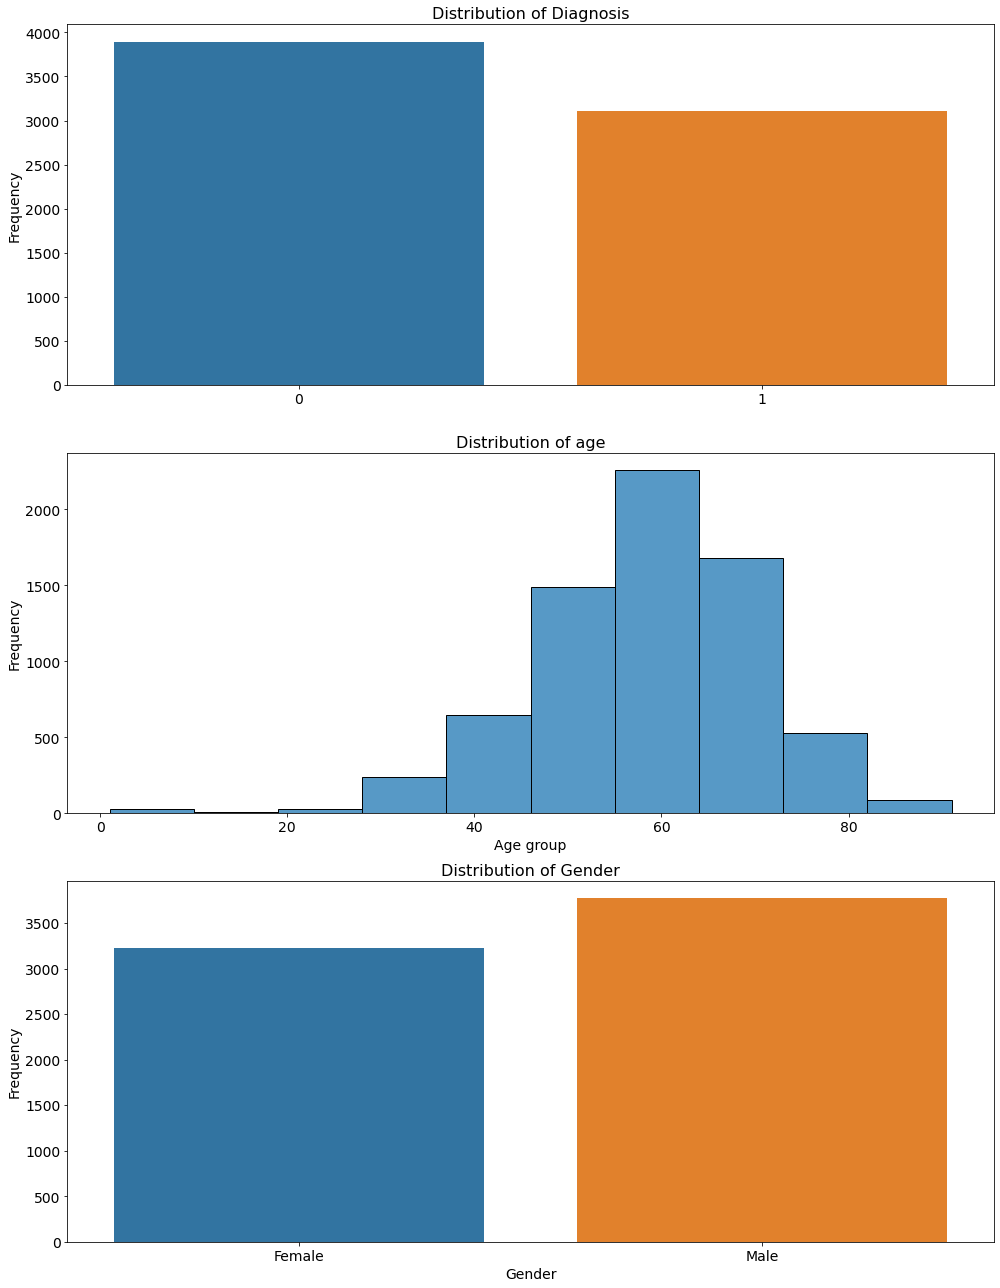

In [17]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (14, 18))

sns.barplot(x=df['Normal'].value_counts(ascending=True).index,
            y=df['Normal'].value_counts(ascending=True).values,
            ax=ax[0])
ax[0].set_title('Distribution of Diagnosis', fontsize=16)
ax[0].set_ylabel('Diagnosis', fontsize=14)
ax[0].set_ylabel('Frequency', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)


sns.histplot(x=df['Patient Age'].sort_values(),bins=10,ax=ax[1])
ax[1].set_title('Distribution of age', fontsize=16)
ax[1].set_xlabel('Age group', fontsize=14)
ax[1].set_ylabel('Frequency', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)

sns.countplot(x=df['Patient Sex'].sort_values(), ax=ax[2])
ax[2].set_title('Distribution of Gender', fontsize=16)
ax[2].set_xlabel('Gender', fontsize=14)
ax[2].set_ylabel('Frequency', fontsize=14)
ax[2].tick_params(axis='both', labelsize=14)


plt.tight_layout();

In [ ]:
#wordcloud on keywords

In [39]:
df['img_format'] = df['filepath'].map(lambda x: Image.open(x).format)
df['img_mode'] = df['filepath'].map(lambda x: Image.open(x).mode)
df['img_size'] = df['filepath'].map(lambda x: Image.open(x).size)

In [41]:
df['img_format'].value_counts()

JPEG    7000
Name: img_format, dtype: int64

In [42]:
df['img_mode'].value_counts()

RGB    7000
Name: img_mode, dtype: int64

In [43]:
df['img_size'].value_counts()

(2592, 1728)    2146
(2048, 1536)     524
(2304, 1728)     424
(1956, 1934)     390
(2736, 1824)     344
                ... 
(1375, 1085)       1
(960, 783)         1
(949, 784)         1
(1470, 1471)       1
(957, 771)         1
Name: img_size, Length: 101, dtype: int64

In [50]:
df[(df['Diagnostic Keywords'].str.contains('low', regex=False) | df['Diagnostic Keywords'].str.contains('lens', regex=False))]

,ID,Patient Age,Patient Sex,Fundus,Diagnostic Keywords,oculus,Normal,filepath,img_format,img_mode,img_size
41,20,64,Female,20_right.jpg,lens dust，normal fundus,R,1,./ODIR-5K/color_fundus/20_right.jpg,JPEG,RGB,"(1936, 1296)"
72,36,55,Male,36_right.jpg,lens dust，normal fundus,R,1,./ODIR-5K/color_fundus/36_right.jpg,JPEG,RGB,"(2592, 1728)"
73,36,55,Male,36_left.jpg,lens dust，spotted membranous change,L,0,./ODIR-5K/color_fundus/36_left.jpg,JPEG,RGB,"(2592, 1728)"
79,39,74,Male,39_right.jpg,lens dust，pathological myopia,R,0,./ODIR-5K/color_fundus/39_right.jpg,JPEG,RGB,"(1936, 1296)"
114,57,64,Male,57_right.jpg,lens dust，drusen，normal fundus,R,1,./ODIR-5K/color_fundus/57_right.jpg,JPEG,RGB,"(2592, 1728)"
...,...,...,...,...,...,...,...,...,...,...,...
6548,4427,43,Male,4427_right.jpg,low image quality,R,0,./ODIR-5K/color_fundus/4427_right.jpg,JPEG,RGB,"(2048, 1536)"
6576,4442,62,Female,4442_left.jpg,low image quality,L,0,./ODIR-5K/color_fundus/4442_left.jpg,JPEG,RGB,"(2992, 2000)"
6586,4448,50,Male,4448_left.jpg,low image quality,L,0,./ODIR-5K/color_fundus/4448_left.jpg,JPEG,RGB,"(2304, 1728)"
6709,4522,67,Male,4522_left.jpg,low image quality,L,0,./ODIR-5K/color_fundus/4522_left.jpg,JPEG,RGB,"(2592, 1944)"


In [34]:
import imageio
image_path = './ODIR-5K/color_fundus/'
def show_images(df):

    f, ax = plt.subplots(3,3, figsize=(16,16))
    for i,idx in enumerate(df.index):
        img_data=imageio.imread(df['filepath'].iloc[idx])
        ax[i//3, i%3].imshow(img_data)
        ax[i//3, i%3].axis('off')
    plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

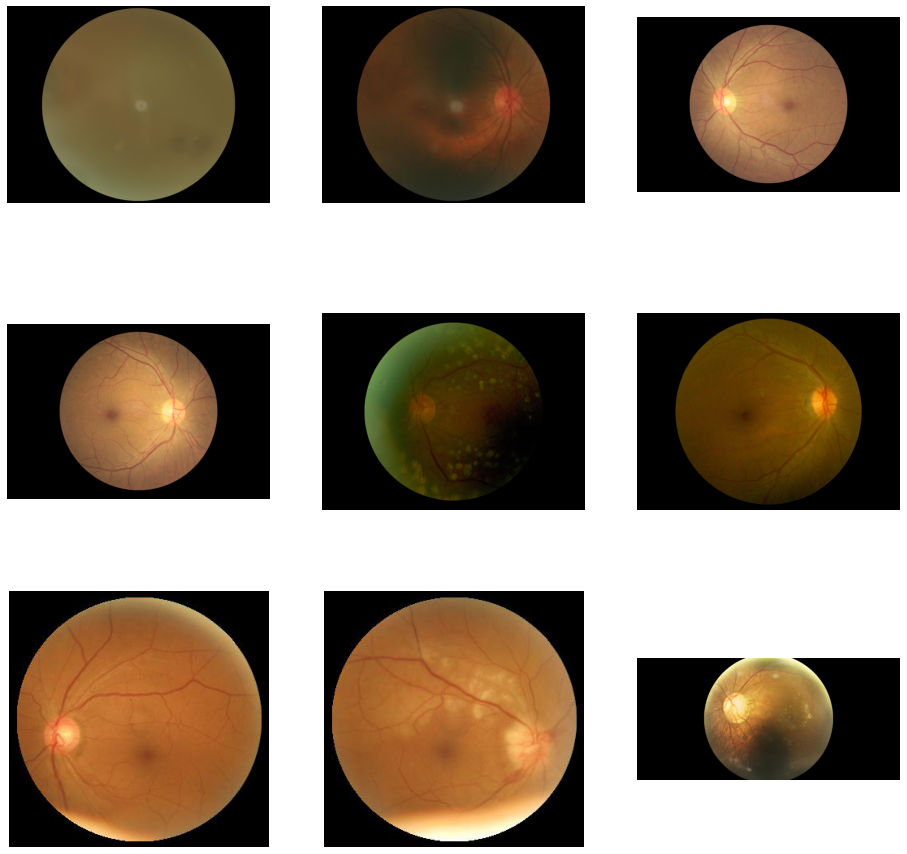

In [35]:
show_images(df)